<div align='center'><font size="5" color='#353B47'>Класификация рукописной кириллицы</font></div>
<div align='center'><font size="4" color="#353B47">Сверточная нейронная сеть</font></div>
<br>
<hr>

## <div id="summary">Содержание</div>

**<font size="2"><a href="#chap1">1. Подготовка</a></font>**
**<br><font size="2"><a href="#chap2">2. Обработка данных</a></font>**
**<br><font size="2"><a href="#chap3">3. Разработка Сверточной нейронной сети </a></font>**
**<br><font size="2"><a href="#chap4">4. Оценка нейронной сети</a></font>**


# <div id="chap1">1. Подготовка</div>

## <font color='blue'>1.1 Библиотеки</font>

In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=835f7752a4cea1f49398d5d1fda2f600c13b4bc714571925b95dbb99b9cd656f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# Remove warning messages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

# navigation and read files
import glob
import os
import wget

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

## <font color='blue'>1.2 Загрузка дата-сетов</font>

In [ ]:
# Path of images
PATH_TO_DATA = '../content/'
CSV_FILES =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [ ]:
wget.download('http://xyla.istu.webappz.ru/nebyl/letters.csv')
wget.download('http://xyla.istu.webappz.ru/nebyl/letters2.csv')
wget.download('http://xyla.istu.webappz.ru/nebyl/letters3.csv')
wget.download('http://xyla.istu.webappz.ru/nebyl/letters.zip')
wget.download('http://xyla.istu.webappz.ru/nebyl/letters2.zip')
wget.download('http://xyla.istu.webappz.ru/nebyl/letters3.zip')

'letters3.zip'

In [ ]:
! unzip /content/letters.zip -d /content/letters/
! unzip /content/letters2.zip -d /content/letters2/
! unzip /content/letters3.zip -d /content/letters3/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/letters3/21_331.png  
  inflating: /content/letters3/__MACOSX/._21_331.png  
  inflating: /content/letters3/21_332.png  
  inflating: /content/letters3/__MACOSX/._21_332.png  
  inflating: /content/letters3/21_333.png  
  inflating: /content/letters3/__MACOSX/._21_333.png  
  inflating: /content/letters3/21_334.png  
  inflating: /content/letters3/__MACOSX/._21_334.png  
  inflating: /content/letters3/21_335.png  
  inflating: /content/letters3/__MACOSX/._21_335.png  
  inflating: /content/letters3/21_336.png  
  inflating: /content/letters3/__MACOSX/._21_336.png  
  inflating: /content/letters3/21_337.png  
  inflating: /content/letters3/__MACOSX/._21_337.png  
  inflating: /content/letters3/21_338.png  
  inflating: /content/letters3/__MACOSX/._21_338.png  
  inflating: /content/letters3/21_339.png  
  inflating: /content/letters3/__MACOSX/._21_339.png  
  inflating: /content/letters3/21_340.png

In [ ]:
def import_data(CSV_FILE):
    data = pd.read_csv(PATH_TO_DATA + CSV_FILE)
    # Create path extention for corresponding folders that contains images
    data['source'] = CSV_FILE[:-4]+'/'
    return data

## <font color='blue'>1.3 Упаковка данных</font>

In [ ]:
data1 = import_data(CSV_FILES[0])
data2 = import_data(CSV_FILES[1])
data3 = import_data(CSV_FILES[2])
data = pd.concat([data1, data2, data3], ignore_index=True)

# I won't use these data anymore
del(data1, data2, data3)

## <font color='blue'>1.4 Перетасовка данных</font>

In [ ]:
# Shuffle data
data = shuffle(data, random_state = 42)

**<font size="2"><a href="#summary">Back to summary</a></font>**

-------

# <div id="chap2">2. Обработка данных</div>

## <font color='blue'>2.1 Унифицирование данных</font>

In [ ]:
data.head()

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/
11270,с,19,19_311.png,3,letters3/
12837,щ,27,27_278.png,3,letters3/


In [ ]:
# Get all labels in one string
letters = ''
for letter in data.letter.unique():
    letters += letter

# Which letter is written on each image
labels = data.label

In [ ]:
def ohe_letters(label):
    '''
    One hot encoding for the target label
    '''
    resu = np.zeros(len(letters))
    index = letters.index(label)
    resu[index] = 1
    return resu

def ohe_backgrounds(label):
    '''
    One hot encoding for background column
    '''
    resu = np.zeros(len(data.background.unique()))
    resu[label] = 1
    return resu

In [ ]:
data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))

In [ ]:
data.head()

,letter,label,file,background,source,encoded_letter,encoded_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


## <font color='blue'>2.2 Изменения размера, фильтрация и нормализация данных</font>

In [ ]:
# Store all png images into one numpy array
images = []
# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# I want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    #os.path.join(PATH_TO_DATA + row['source'], img_name)
    numpy_image = cv2.imread("../content/"+row['source']+img_name)

    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['encoded_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['encoded_background'])

# Normalize array of images
images = np.array(images)/255

## <font color='blue'>2.3 Вывод букв</font>

In [ ]:
def display_image(images_list, list_of_labels = np.arange(9)):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:

        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]


        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

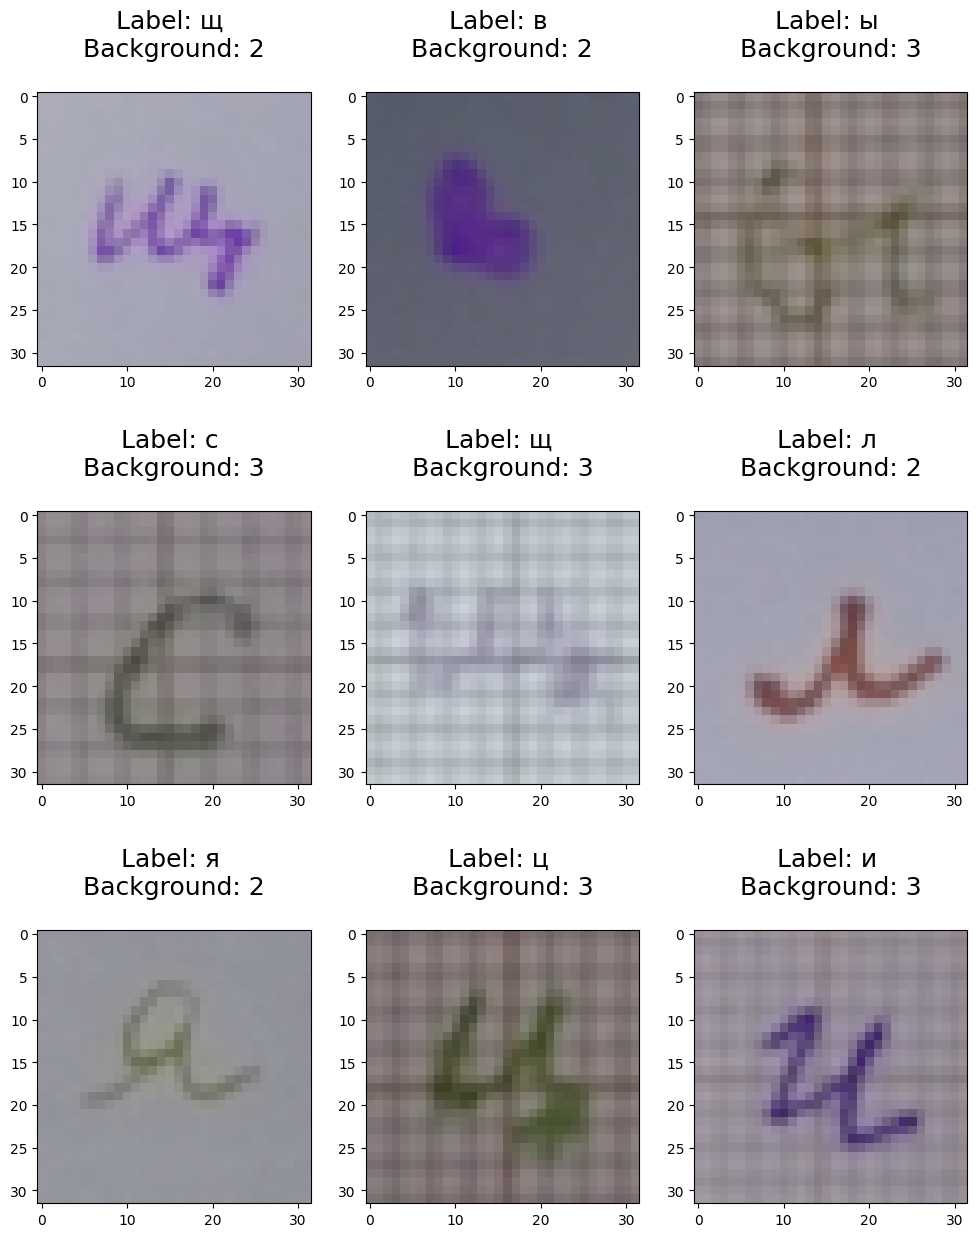

In [ ]:
display_image(images)

## <font color='blue'>2.4 Подготовка обучающей и тестировочной выборки</font>

In [ ]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)

**<font size="2"><a href="#summary">Back to summary</a></font>**

------

# <div id="chap3">3. Разработка Сверточной нейронной сети</div>

## <font color='blue'>3.1 Параментры нейронной сети</font>

In [ ]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 10

In [ ]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## <font color='blue'>3.2 Сверточная нейронная сеть</font>

In [ ]:
def CNN_model(activation = 'softmax',
              loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', top_3_categorical_accuracy]):

    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))

    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    return model

In [ ]:
# Init CNN model
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.hdf5',
                               verbose = 2,
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=2,
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])

Epoch 1/10
178/178 [==============================] - ETA: 0s - loss: 3.4325 - accuracy: 0.0510 - top_3_categorical_accuracy: 0.1356
Epoch 1: val_loss improved from inf to 2.80543, saving model to weights.best.letters.hdf5
178/178 [==============================] - 221s 1s/step - loss: 3.4325 - accuracy: 0.0510 - top_3_categorical_accuracy: 0.1356 - val_loss: 2.8054 - val_accuracy: 0.2176 - val_top_3_categorical_accuracy: 0.4549 - lr: 0.0010
Epoch 2/10
178/178 [==============================] - ETA: 0s - loss: 2.5283 - accuracy: 0.2874 - top_3_categorical_accuracy: 0.5125
Epoch 2: val_loss improved from 2.80543 to 1.88962, saving model to weights.best.letters.hdf5
178/178 [==============================] - 215s 1s/step - loss: 2.5283 - accuracy: 0.2874 - top_3_categorical_accuracy: 0.5125 - val_loss: 1.8896 - val_accuracy: 0.4665 - val_top_3_categorical_accuracy: 0.6971 - lr: 0.0010
Epoch 3/10
178/178 [==============================] - ETA: 0s - loss: 1.8731 - accuracy: 0.4680 - top_3_

## <font color='blue'>3.3 График обучения нейронной сети</font>

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top_3_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_3_categorical_accuracy', 'lr'])


In [ ]:
def plot_history(model_history):

    plt.figure(figsize = (20,15))

    plt.subplot(221)
    # summarize history for accuracy
    plt.plot(model_history.history['top_3_categorical_accuracy'])
    plt.plot(model_history.history['val_top_3_categorical_accuracy'])
    plt.title('top_3_categorical_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.subplot(222)
    # summarize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.subplot(223)
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.subplot(224)
    # summarize history for lr
    plt.plot(model_history.history['lr'])
    plt.title('learning rate')
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.grid()

    plt.show()

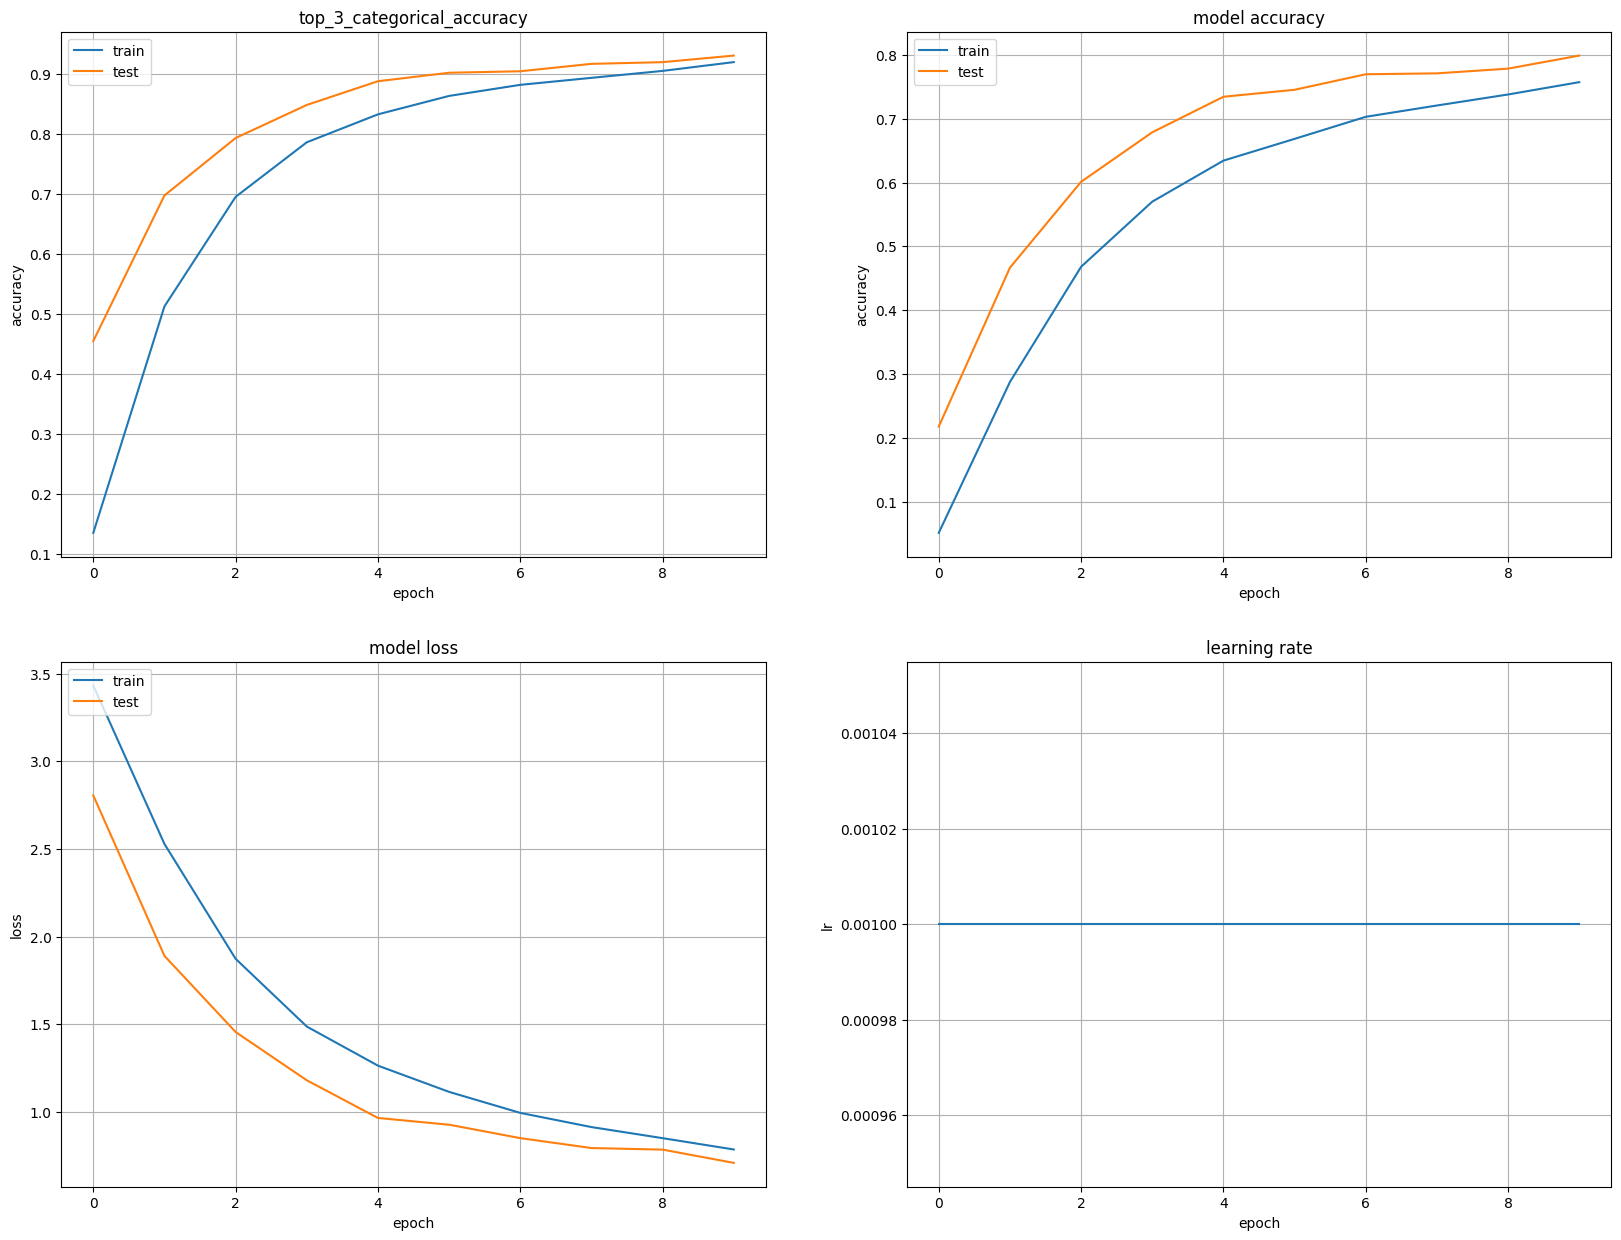

In [ ]:
plot_history(history)

**<font size="2"><a href="#summary">Back to summary</a></font>**

------

# <div id="chap1">4. Оценка нейронной сети</div>

In [ ]:
# loading the model with the best validation accuracy
cnn_model.load_weights('weights.best.letters.hdf5')
cnn_model.evaluate(X_val, y_val)

89/89 [==============================] - 12s 129ms/step - loss: 0.7085 - accuracy: 0.7990 - top_3_categorical_accuracy: 0.9298


[0.7085147500038147, 0.7990127205848694, 0.9298307299613953]

## <font color='blue'>4.1 Проверка одной буквы</font>

In [ ]:
def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [ ]:
def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

In [ ]:
img = load_image(PATH_TO_DATA+'letters3/01_235.png')

1/1 [==============================] - 0s 44ms/step
Предсказано: а
Настоящие значение: а


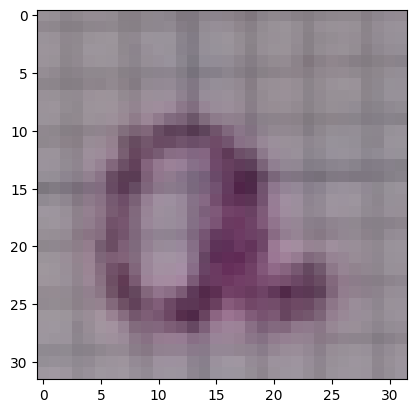

In [ ]:
# predict the class
#a_letter = cnn_model.predict_classes(img)
a_letter = np.argmax(cnn_model.predict(img), axis=-1)

plt.imshow(img[0])
print('Предсказано:', letters[a_letter[0]])
print('Настоящие значение:', get_true_label(PATH_TO_DATA+'letters3/01_235.png', data, 'letter'))

## <font color='blue'>4.2 Проверка массива букв</font>

In [ ]:
def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []

    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))

        index_image = random.randint(0, len(os.listdir(path)))

        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)

    return images, true_labels, true_backgrounds

In [ ]:
def classes_predictions(images_list_to_classify, true_labels, model):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):

       #a_letter = model.predict_classes(image)
        a_letter = np.argmax(model.predict(image), axis=-1)
        associated_letter = letters[a_letter[0]]

        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Нейросеть: %s \n'%associated_letter+\
                  'Реальное значение: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)

    # show the figure
    plt.show()

In [ ]:
test_images, true_labels, true_backgrounds = load_random_images()

1/1 [==============================] - 0s 29ms/step


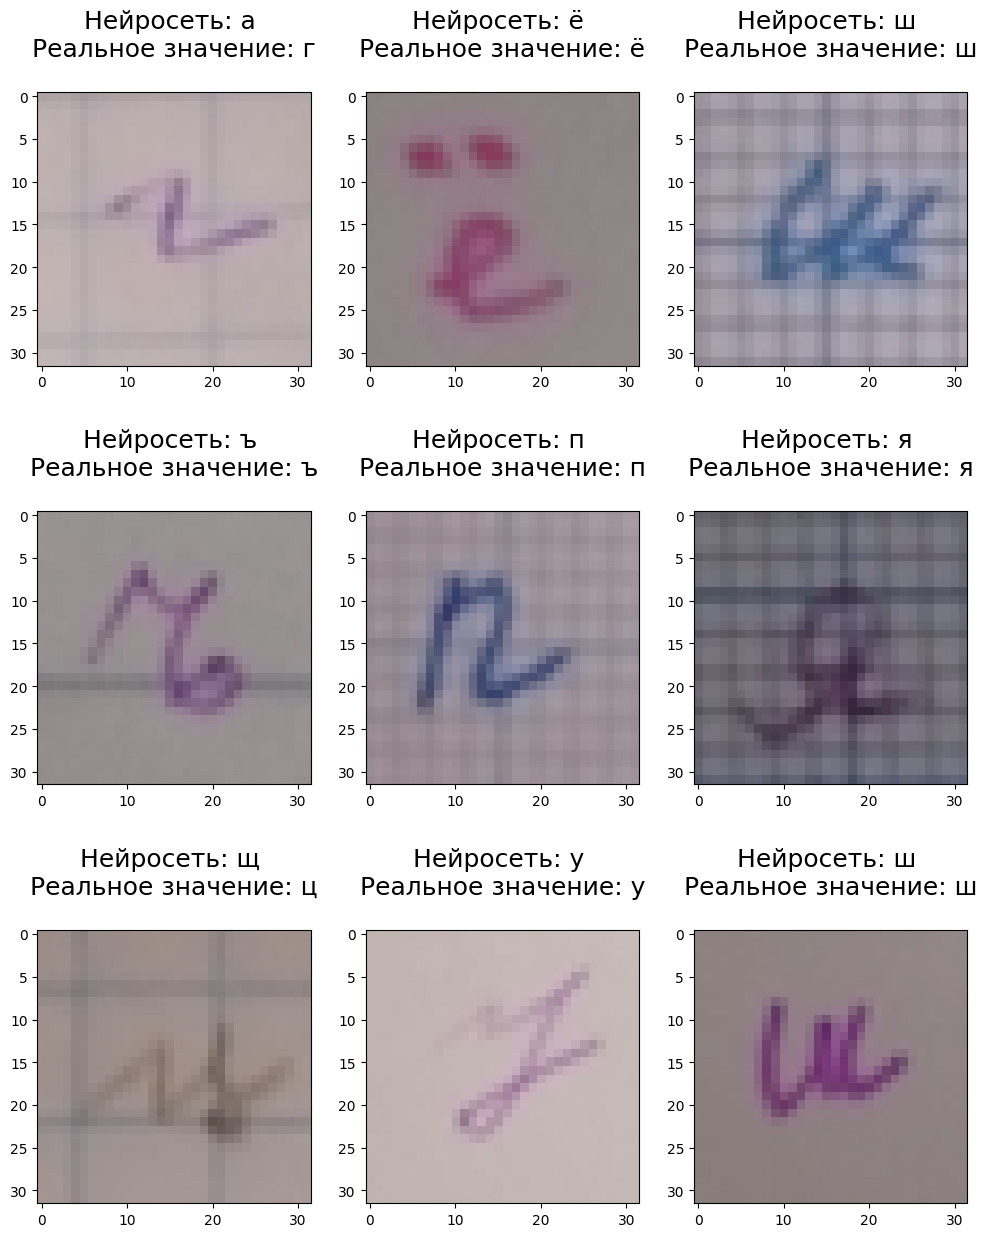

In [ ]:
classes_predictions(test_images, true_labels, cnn_model)